In [1]:
note="hexpaper_fig2"

In [2]:
# This one uses processed Ws inputs, so one does not have to input the array sizes manually
import qpms
from qpms.symmetries import  gen_hexlattice_Kpoint_svwf_rep, gen_hexlattice_Kpoint_svwf_rep_projectors
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath

In [3]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [4]:
irrepnames_latex = {"E'": "$E'$", "A1'": "$A_1'$", "A2'" : "$A_2'$", "E''":"$E''$", "A1''":"$A_1''$", "A2''" : "$A_2''$"}

In [5]:
Wfile = '/m/phys/project/qd/Marek/deep_thin_cs/lMax3zoom2'
#force_lMax = 2
#nelem = force_lMax * (force_lMax+2)

In [6]:
#wdata = wdata_long
wdata = qpms.loadWfile_processed(Wfile, lMax=3, midk_halfwidth=1, #freqlimits=(1.44075*eV/ℏ,1.44125*eV/ℏ)
                                 freqlimits=(1.435*eV/ℏ,1.445*eV/ℏ)
                                 #freqlimits=(1.439*eV/ℏ,1.442*eV/ℏ)
                                )
lMax = wdata['lMax']
nelem = wdata['nelem']

In [7]:
#wdata.keys(), wdata['nk'], wdata['ks'], wdata['Ws'].shape

In [8]:
#### T-matrices from file
# Original Ag:
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax3_longer_cleaned.TMatrix'

TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper_freqscale_finer/cylinder_50nm_lMax3_longer_freqdiv20_cleaned.TMatrix'
freqscale=20
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new', freqscale=freqscale)
tmtype="Scuff"

In [9]:
# TODO synchronize the TM/W lMaxes better
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
lMaxTM = lMax

In [10]:
freqs_orig[0] / (eV/hbar), freqs_orig[-1] / (eV/hbar)

(0.19732697880919509, 2.1705967669011454)

#### Alternatively, Mie T-matrix
#lMaxTM = force_lMax
lMax = lMaxTM

nelem = lMax * (lMax + 2)
startω =1*eV/ℏ
stopω = 2*eV/ℏ
ωlist = np.linspace(startω, stopω, 200)


ε_b = 2.13
R = 40e-9

if False: # drude model
    ω_p = 9*eV/ℏ #9*eV/ℏ
    ε_inf = 4.6
    γ_p = 0#0.07*eV/ℏ
    
    ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)
    tmtype="MieDrude%gnm" % (R/1e-9)
else: # interpolated data
    permdata = np.loadtxt("/u/46/necadam1/unix/tmatrix-experiments/materialy/Au-Johnson-simple.dat")
    permfreqs = permdata[:,0]
    permvals = permdata[:,1] + permdata[:,2]*1j
    permdata_interp = interpolate.interp1d(permfreqs, permvals, axis = 0, kind='linear', fill_value='extrapolate')
    ε_mlist = permdata_interp(ωlist)
    tmtype="MieInterp%gnm" % (R/1e-9)
    

RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

y = np.arange(nelem)
my, ny = qpms.get_mn_y(lMax)

TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

for l in range(1,lMax+1):
    beg = l**2-1
    end = l*(l+2)
    TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
    TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

freqs_orig = ωlist

In [11]:
lMax = lMaxTM  # redundant
nelem = qpms.get_nelem(lMax) #redundant
nomega = wdata['nfreqs'] # 286
nk = wdata['nk'] #100
npart = wdata['npart']
wdata['freqs'][0]/(eV/hbar), wdata['freqs'][-1] / (eV/hbar)

(1.4350012552962281, 1.444995866772914)

In [12]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [13]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [14]:
Wmatrices = wdata['Ws']#.reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = np.broadcast_to(wdata['ks'][ň,:,:], (nomega, nk, 2))
freqs = np.broadcast_to(wdata['freqs'][:,ň], (nomega,nk))

Wmatrices.shape, ks.shape, freqs.shape


((1494, 3, 2, 2, 15, 2, 2, 15), (1494, 3, 2), (1494, 3))

In [15]:
TMatrices_orig.shape, ks.shape, freqs.shape

((157, 2, 15, 2, 15), (1494, 3, 2), (1494, 3))

In [16]:
lineindex = nk//2
linek = ks[0,lineindex]
linefreqs = freqs[:,lineindex]
lineWmatrices = Wmatrices[:,lineindex]


# Checks

In [17]:
# "Final" SVD problem matrices to test projections onto irrep subspace
finalMatrices = np.empty((nomega, npart,2,nelem, npart,2,nelem), dtype=complex)
# Full problem
for omi in range(nomega):
        W = lineWmatrices[omi]
        T = TMatrices_interp(linefreqs[omi])
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        finalMatrices[omi] = finalMatrix

In [18]:
### Zde se vybírá ""číslo"" modu
psi = 1
reps =  gen_hexlattice_Kpoint_svwf_rep(lMax, psi, vflip='y')
projmats, bases = gen_hexlattice_Kpoint_svwf_rep_projectors(lMax,psi, vflip='y',do_bases=True)

In [19]:
bases["E''"].shape

(20, 2, 2, 15)

In [20]:
projmats["E''"].shape

(2, 2, 15, 2, 2, 15)

In [21]:
reps["E''"].shape

(2, 2, 2, 2, 15, 2, 2, 15)

In [22]:
# test whether the symmetry group is correct (now mainly whether the psi sign is correct)
finalMatrices_projs = dict()
for rep, P in projmats.items():
    MP = np.tensordot(finalMatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PMP = np.tensordot(P,MP, axes=([-3,-2,-1],[1,2,3]))
    PMP = np.rollaxis(PMP, 3)
    finalMatrices_projs[rep] = PMP

finalMatrices_reconstructed = np.zeros(finalMatrices.shape, dtype=complex)
for PMP in finalMatrices_projs.values():
    finalMatrices_reconstructed += PMP

In [23]:

np.amax(np.abs(finalMatrices-finalMatrices_reconstructed))
#finalMatrices[0]
#finalMatrices_reconstructed[0]
#finalMatrices[0]-finalMatrices_reconstructed[0]

2.1349544370502435e-08

In [24]:
TMatrices_projs = dict()
fullTMatrices = np.zeros((nomega, npart,2,nelem,npart,2,nelem), dtype=complex)
for omi in range(nomega):
    fullTMatrices[omi,0,:,:,0,:,:] = TMatrices_interp(linefreqs[omi])
    fullTMatrices[omi,1,:,:,1,:,:] = TMatrices_interp(linefreqs[omi])
for rep, P in projmats.items():
    TP = np.tensordot(fullTMatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PTP = np.tensordot(P,TP, axes=([-3,-2,-1],[1,2,3]))
    PTP = np.rollaxis(PTP, 3)
    TMatrices_projs[rep] = PTP

TMatrices_reconstructed = np.zeros(fullTMatrices.shape, dtype=complex)
for PTP in TMatrices_projs.values():
    TMatrices_reconstructed += PTP

In [25]:
np.amax(np.abs(TMatrices_reconstructed-fullTMatrices))

1.3877787807814457e-17

# Irrep SVs at K

In [26]:
WMatrices_projs = dict()
for rep, P in projmats.items():
    WP = np.tensordot(lineWmatrices, P, axes=([-3,-2,-1],[0,1,2]))
    PWP = np.tensordot(P,WP, axes=([-3,-2,-1],[1,2,3]))
    PWP = np.rollaxis(PWP, 3)
    WMatrices_projs[rep] = PWP

WMatrices_reconstructed = np.zeros(lineWmatrices.shape, dtype=complex)
for PWP in WMatrices_projs.values():
    WMatrices_reconstructed += PWP

In [27]:
(np.amax(np.nan_to_num(np.abs(WMatrices_reconstructed-lineWmatrices)/(np.abs(WMatrices_reconstructed)+np.abs(lineWmatrices)))),
 np.amax(np.abs(WMatrices_reconstructed-lineWmatrices)))

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(1.0, 7.963936141273393e-08)

## Solve

In [28]:
lineS_irrep = dict()
for rep, B in bases.items():
    N = B.shape[0]
    lineS_thisirrep = np.full((nomega,N), np.nan)
    #B_H = np.moveaxis(B,0, -1).conj() # (N,2,2,nelem) -> (2,2,nelem,N)
    B_H = B.conj()
    B = np.moveaxis(B,0,-1)
    for omi in range(nomega):
            M = finalMatrices[omi]
            MB = np.tensordot(M,B,axes=([-3,-2,-1],[0,1,2]))
            finalMatrix_irrep = np.tensordot(B_H, MB, axes=([-3,-2,-1],[0,1,2]))
            try:
                #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                lineS_thisirrep[omi] = scipy.linalg.svd(finalMatrix_irrep, compute_uv = False,
                                                                           # lapack_driver= 'gesvd'
                                                                           )
            except ValueError:
                pass
    lineS_irrep[rep] = lineS_thisirrep


## Plot

[1.43797103 1.44111208 1.44110655]
<a list of 6 Text xtickline objects>
E' 1.4379710263273067
A1' 1.4411120771759915
A2' 1.4411065520205848
E'' 1.4411049734047545
A1'' 1.4410852407068735
A2'' 1.4410994482493475


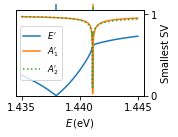

In [29]:
%matplotlib inline

plotreps = ["E'",  "A1'",  "A2'",  
            #"E''", "A1''", "A2''"
           ]

from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
#plt.gcf().subplots_adjust(right=0.5)
repcolors = {}
repls = {}

s = 1
f, ax = plt.subplots(1,1, figsize=(2.5,1.8))
f.subplots_adjust(bottom=0.26,left=0.09,top=0.92,right=0.80)
reppeakfreqs = dict()
for rep in plotreps:
    lineSp = lineS_irrep[rep]
    p = ax.plot(linefreqs/eV*hbar, lineSp[:,-s], label=irrepnames_latex[rep], ls = ':' if rep=="A2'" else None)
    reppeakfreqs[rep] = linefreqs[np.argmin(lineSp[:,-s])]
    repcolors[rep] = p[-1].get_color()
    repls[rep] = p[-1].get_linestyle()
ax.set_ylim([0,1.05])
ax.set_yticks([0,1])
ax.set_ylabel("Smallest SV")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
#ax.set_xlim([1.441, 1.4412])
#ax.set_xticks([1.441, 1.4411, 1.4412])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))
ax.set_xlabel('$E\,(\mathrm{eV})$')
ax2 = ax.twiny()
ax2.set_xlim([ax.get_xlim()[0],ax.get_xlim()[1]])
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.set_xticks([linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar for rep in plotreps])
print(ax2.get_xticks())
ax.legend(prop={'size': 8.5})
print(ax2.get_xticklines())
ax2.xaxis.set_tick_params(size=6, width=1.5)
for  i, tick in enumerate(ax2.get_xticklines()):
    #print(tick)
    tick.set_color(repcolors[plotreps[i//2]]) # For some reason, there are 2*len(plotreps) Line2D objects.
    tick.set_linestyle(repls[plotreps[i//2]]) # For some reason, there are 2*len(plotreps) Line2D objects.
    if (plotreps[i//2] == "A2'"): # hack the A1' tick visibility here
        tick.set_markersize(3)
    #if(i<2): tick.set_marker('o')
plt.savefig("../../../hexlaser/figs/fig2SVs.pdf")
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    print(rep, linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar)

In [30]:
print(np.argmin(lineS_irrep["E'"][:,-s]))

301


In [31]:
print(freqs_weirdunits_orig.shape)

(157,)


In [32]:
wdata["freqs_weirdunits"][900]

7.2825

[1.44111208 1.44110655]
<a list of 4 Text xtickline objects>
E' 1.4379710263273067
A1' 1.4411120771759915
A2' 1.4411065520205848
E'' 1.4411049734047545
A1'' 1.4410852407068735
A2'' 1.4410994482493475


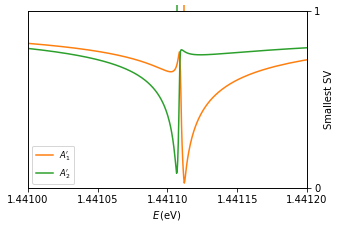

In [53]:
%matplotlib inline

plotreps = [#"E'",  
            "A1'",  "A2'",  
            #"E''", 
    #"A1''", 
    #"A2''"
           ]

#rcParams.update({'figure.autolayout': True})
#plt.gcf().subplots_adjust(right=0.5)
repcolors = {}
repls = {}

s = 1
f, ax = plt.subplots(1,1, figsize=(5,3))
#f.subplots_adjust(bottom=0.26,left=0.09,top=0.92,right=0.80)
f.subplots_adjust(bottom=0.15, top=0.97)
reppeakfreqs = dict()
ax.plot([], []) # null plot to advance the color cycler
for rep in plotreps:
    lineSp = lineS_irrep[rep]
    p = ax.plot(linefreqs/eV*hbar, lineSp[:,-s], label=irrepnames_latex[rep], #ls = ':' if rep=="A2'" else None
               )
    reppeakfreqs[rep] = linefreqs[np.argmin(lineSp[:,-s])]
    repcolors[rep] = p[-1].get_color()
    repls[rep] = p[-1].get_linestyle()
ax.set_ylim([0,1.00])
ax.set_yticks([0,1])
ax.set_ylabel("Smallest SV")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlim([1.441, 1.4412])
#ax.set_xticks([1.441, 1.4411, 1.4412])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins='4'))
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useOffset=False))

ax.set_xlabel('$E\,(\mathrm{eV})$')
ax2 = ax.twiny()
ax2.set_xlim([ax.get_xlim()[0],ax.get_xlim()[1]])
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.set_xticks([linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar for rep in plotreps])
print(ax2.get_xticks())
ax.legend(prop={'size': 8.5})
print(ax2.get_xticklines())
ax2.xaxis.set_tick_params(size=6, width=1.5)
for  i, tick in enumerate(ax2.get_xticklines()):
    #print(tick)
    tick.set_color(repcolors[plotreps[i//2]]) # For some reason, there are 2*len(plotreps) Line2D objects.
    tick.set_linestyle(repls[plotreps[i//2]]) # For some reason, there are 2*len(plotreps) Line2D objects.
    #if (plotreps[i//2] == "A2'"): # hack the A1' tick visibility here
    #    tick.set_markersize(3)
    #if(i<2): tick.set_marker('o')

plt.savefig("../../../hexlaser/supfigs/fig2SVs_large.pdf")
for rep in ["E'", "A1'", "A2'", "E''", "A1''", "A2''"]:
    print(rep, linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar)